  # Multiclass Support Vector Machine exercise

  *Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa19.github.io/assignments2019/assignment1/) on the course website.*

  In this exercise you will:

  - implement a fully-vectorized **loss function** for the SVM
  - implement the fully-vectorized expression for its **analytic gradient**
  - **check your implementation** using numerical gradient
  - use a validation set to **tune the learning rate and regularization** strength
  - **optimize** the loss function with **SGD**
  - **visualize** the final learned weights


In [1]:
### IF YOU ARE USING COLAB, UNCOMMENT AND RUN THIS BLOCK FIRST ###

# # Mount google drive to allow access to your files
# from google.colab import drive
# drive.mount('/content/drive')
# drive_folder = '/content/drive/MyDrive'
# # Ajust this line to be the assignment1 folder in your google drive
# notebook_folder = drive_folder + '/cs682/assignment1'
# %cd {notebook_folder}

In [2]:
# Run some setup code for this notebook.
from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import itertools

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

  ## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs682/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass
# Don't forget to run get_datasets.sh, or this will throw an error
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


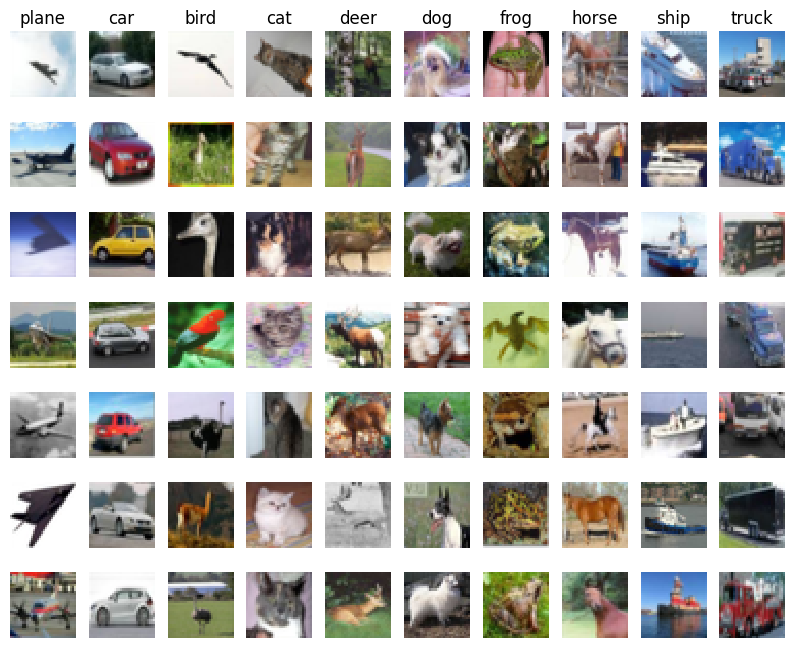

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


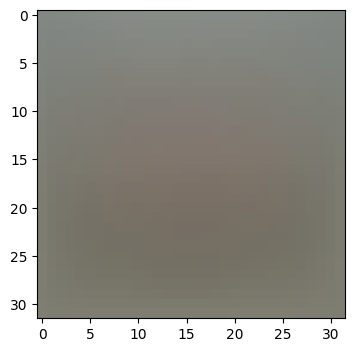

In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


  ## SVM Classifier

  Your code for this section will all be written inside **cs682/classifiers/linear_svm.py**.

  As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function.

In [10]:
# Evaluate the naive implementation of the loss we provided for you:
from cs682.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.396832


  The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

  To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [11]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs682.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 11.013842 analytic: 11.013842, relative error: 9.043841e-12
numerical: 11.279448 analytic: 11.317793, relative error: 1.696881e-03
numerical: -2.926004 analytic: -2.926004, relative error: 6.302081e-12
numerical: -20.605171 analytic: -20.588060, relative error: 4.153829e-04
numerical: 3.951582 analytic: 3.951582, relative error: 6.036127e-12
numerical: 4.335107 analytic: 4.335107, relative error: 1.147496e-10
numerical: 13.451774 analytic: 13.451774, relative error: 7.366815e-12
numerical: -15.632733 analytic: -15.632733, relative error: 1.055878e-11
numerical: 16.182883 analytic: 16.182883, relative error: 2.245121e-11
numerical: 29.217532 analytic: 29.217532, relative error: 7.880042e-12
numerical: 1.717264 analytic: 1.717264, relative error: 3.791756e-11
numerical: 45.078024 analytic: 45.078024, relative error: 7.036857e-12
numerical: 19.568753 analytic: 19.568753, relative error: 6.757303e-13
numerical: 27.952740 analytic: 27.952740, relative error: 1.315710e-12
numerica

In [12]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs682.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.396832e+00 computed in 0.847283s
Vectorized loss: 8.396832e+00 computed in 0.029333s
difference: -0.000000


  ### Stochastic Gradient Descent

  We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs682.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 794.152701
iteration 100 / 1500: loss 287.323656
iteration 200 / 1500: loss 107.234748
iteration 300 / 1500: loss 43.395405
iteration 400 / 1500: loss 19.035865
iteration 500 / 1500: loss 10.113190
iteration 600 / 1500: loss 6.796887
iteration 700 / 1500: loss 6.128926
iteration 800 / 1500: loss 5.569843
iteration 900 / 1500: loss 5.614940
iteration 1000 / 1500: loss 5.308732
iteration 1100 / 1500: loss 5.290466
iteration 1200 / 1500: loss 5.398831
iteration 1300 / 1500: loss 5.171729
iteration 1400 / 1500: loss 5.137407
That took 18.715519s


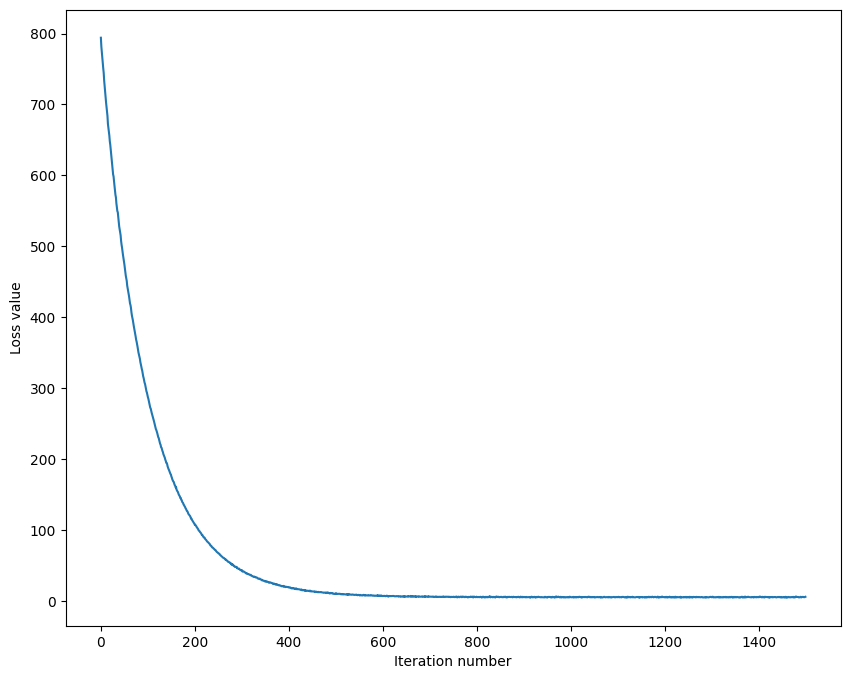

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.364510
validation accuracy: 0.374000


In [16]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5]
regularization_strengths = [1e3, 2e3, 3e3, 4e3, 5e3, 1e4, 2e4, 2.5e4, 3e4, 3.5e4, 4e4, 4.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
best_combo = ()

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# Your code
combos = [(v[0], v[1]) for v in list(itertools.product(learning_rates, regularization_strengths))]
for combo in combos:
    print('\nEvaluating combo: ', combo)
    svm = LinearSVM()
    loss_hist = svm.train(X_train, y_train, learning_rate=combo[0], reg=combo[1], num_iters=1500,
                        verbose=True)
    
    y_train_pred = svm.predict(X_train)
    y_val_pred = svm.predict(X_val)
    train_accuracy = np.mean(y_train == y_train_pred)
    val_accuracy = np.mean(y_val == y_val_pred)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_svm = svm
        best_combo = combo
    results[combo] = (train_accuracy, val_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

print('\n\n')
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print(f'\nbest validation accuracy achieved during cross-validation: {best_val} and the alpha, regularization that achieved it: {best_combo}')


Evaluating combo:  (1e-07, 1000.0)
iteration 0 / 1500: loss 51.446740
iteration 100 / 1500: loss 39.036991
iteration 200 / 1500: loss 38.819472
iteration 300 / 1500: loss 35.923849
iteration 400 / 1500: loss 33.664419
iteration 500 / 1500: loss 31.318535
iteration 600 / 1500: loss 31.473771
iteration 700 / 1500: loss 28.329358
iteration 800 / 1500: loss 29.004411
iteration 900 / 1500: loss 27.913152
iteration 1000 / 1500: loss 27.065112
iteration 1100 / 1500: loss 24.692321
iteration 1200 / 1500: loss 25.083797
iteration 1300 / 1500: loss 22.632568
iteration 1400 / 1500: loss 22.873037

Evaluating combo:  (1e-07, 2000.0)
iteration 0 / 1500: loss 82.794547
iteration 100 / 1500: loss 67.981975
iteration 200 / 1500: loss 62.428012
iteration 300 / 1500: loss 55.490350
iteration 400 / 1500: loss 50.126436
iteration 500 / 1500: loss 49.033610
iteration 600 / 1500: loss 45.047173
iteration 700 / 1500: loss 39.763640
iteration 800 / 1500: loss 38.785726
iteration 900 / 1500: loss 34.353283
it

/home/mikasaackerman/umass-amherst/courses/semester-1/cs682/hw/assignment1/cs682/classifiers/linear_svm.py:85: RuntimeWarning: overflow encountered in scalar multiply
  loss += (reg * np.sum((W*W)))
/home/mikasaackerman/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/mikasaackerman/umass-amherst/courses/semester-1/cs682/hw/assignment1/cs682/classifiers/linear_svm.py:85: RuntimeWarning: overflow encountered in multiply
  loss += (reg * np.sum((W*W)))


iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf

Evaluating combo:  (3e-05, 45000.0)
iteration 0 / 1500: loss 1420.785727
iteration 100 / 1500: loss 25283602663329509224525147949587963367107311173632.000000
iteration 200 / 1500: loss 310901797062798405310242397731510253997890642132055903956915635112679136106184920047890907267072.000000
iteration 300 / 1500: loss 3823028256850032614750123116244810129649734391575620299133690793942552368846361158910757480777966394648535395879358809074959784756081701421056.000000
iteration 400 / 1500: loss 47010165881162908731496555264213202967756046850966446183142251812066957633874854145582974681781570569094758854882143641971321275308030560918953981544136972422535962171065433460853161590784.000000
iteration 500 / 1500: loss 57806418046078917577999948913529795777459584702397528542950807346279158986041499294884487145475918218232862617914613691681813183420862356519696680669393565

/home/mikasaackerman/umass-amherst/courses/semester-1/cs682/hw/assignment1/cs682/classifiers/linear_svm.py:110: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W
/home/mikasaackerman/umass-amherst/courses/semester-1/cs682/hw/assignment1/cs682/classifiers/linear_svm.py:81: RuntimeWarning: overflow encountered in subtract
  svm_fx = WSum - Yscore + delta
/home/mikasaackerman/umass-amherst/courses/semester-1/cs682/hw/assignment1/cs682/classifiers/linear_svm.py:81: RuntimeWarning: invalid value encountered in subtract
  svm_fx = WSum - Yscore + delta
/home/mikasaackerman/umass-amherst/courses/semester-1/cs682/hw/assignment1/cs682/classifiers/linear_classifier.py:72: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


iteration 1400 / 1500: loss nan

Evaluating combo:  (3e-05, 50000.0)
iteration 0 / 1500: loss 1561.053947
iteration 100 / 1500: loss 3064059894584812013257219787941490216566958132081680865006977024.000000
iteration 200 / 1500: loss 4923754414496525725066854620577410911721728327477951407576585379082763399705747916002975984886135805713345323769165747585024.000000
iteration 300 / 1500: loss 7912168289242616805946020561957238991553605003924694443182025524389162023575940252870917580669156885699184925616262997853407548459261507606368306810805246484353356210063436847224193024.000000
iteration 400 / 1500: loss 12714364236563531536953746000700253562081163480413158801636599666991183813666828658041479749646485661618531841115146336105736237829961833592503013422875515270041696998586898507989235195619538285617402988424780632813936127788687113113221436801024.000000
iteration 500 / 1500: loss 20431195600299851346693223849000531463392910790683175276398532149988445999442233605189481059576817512928687451

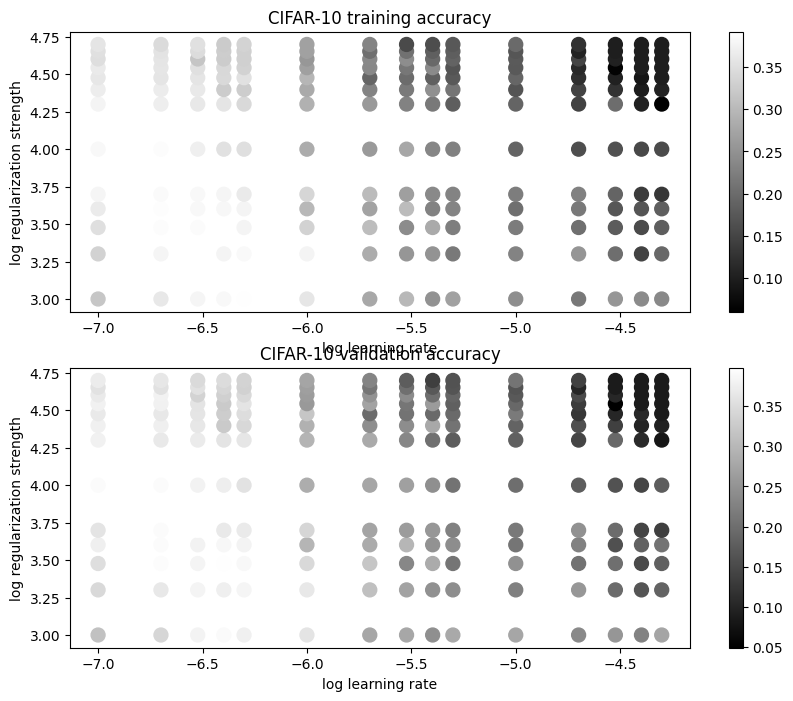

In [17]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [18]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.378000


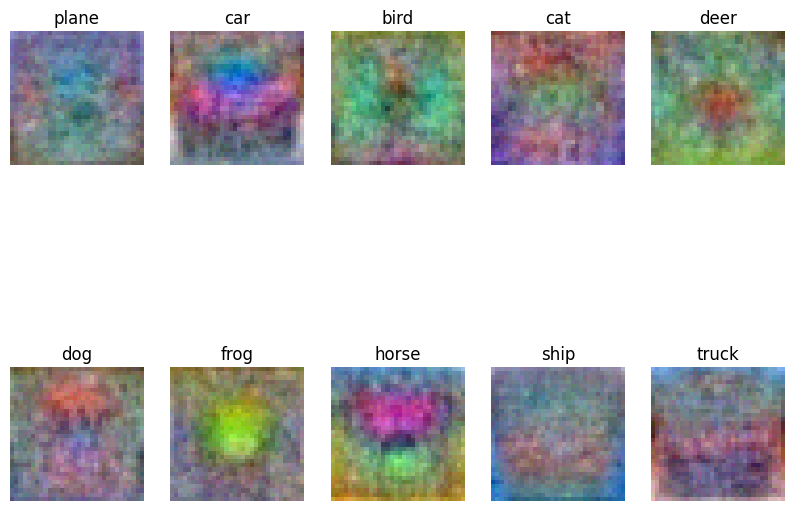

In [19]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

  ### Inline question 2:
  Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

  **Your answer:**\
  Each image represents the learned SVM weights of the class and captures the shape and orientation of the objects found in the dataset.
  For eg - the shape of frog is discernible by the greenish yellow tinge in the visualized raw weights, as well as its position.
  This means that the dataset has frogs mostly at the center.
  Another eg of this is the bird class. One can make out 2 sets of shapes in the visualized weights signifying that the dataset has birds facing either left or right
  The svm weights visualization tries to capture position, orientation and shape from the whole dataset, causing the imags to look the way they do.
